In [112]:
from sys import stdout

import numpy as np
from numpy.polynomial.polynomial import Polynomial, polyfit, polyval
import sympy as sp
from sympy import symbols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as _A  # imported for "side effects"
from IPython.display import display

import heisenberg

## The parameters: Generating set and n

In [8]:
S = [
    # Don't include 0 because it should give the same answer as counting all those 
    # np.array(( 0,  0,  0)),
    np.array(( 1,  0,  0)),
    np.array(( 0,  1,  0)),
    np.array(( 0,  0,  1)),
    np.array((-1,  0,  0)),
    np.array(( 0, -1,  0)),
    np.array(( 0,  0, -1)),
]

In [34]:
n = 9

Computing Heisenberg sums on S = [array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([-1,  0,  0]), array([ 0, -1,  0]), array([ 0,  0, -1])]...
showing h3


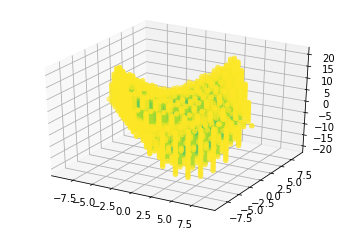

In [35]:
print("Computing Heisenberg sums on S = {}...".format(S))
p_n = list(heisenberg.compute_h3_pn_spheres(S, n))

plotted_h3 = heisenberg.PlotForm.from_spheres(p_n)
fig = plt.figure()
print("showing h3")
plotted_h3.plotme(fig)
plt.show(fig)

# Fitting a polynomial to the number of points
We'll generate, say, 8 numbers-of-points and then pick 5 (the first 5?) to fit it to, then test on the remaining numbers. To be sure.

In [143]:
P_k_sizes = [
    (
        k,
        len(
            set(
                tuple(point) for (point, i) in p_n if i <= k
            )
        )
    )
    for k in range(1, n+1)
]
P_k_sizes

[(1, 6),
 (2, 29),
 (3, 83),
 (4, 189),
 (5, 379),
 (6, 697),
 (7, 1199),
 (8, 1953),
 (9, 3039)]

In [144]:
# Now let's fit a polynomial to it
POLYNOMIAL_DEGREE = 4
fit_inputs = [k for (k, _) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]
fit_outputs = [size for (_, size) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]

p = Polynomial.fit(fit_inputs, fit_outputs, deg=POLYNOMIAL_DEGREE)
p.convert().coef[::-1]

array([ 0.45833333, -1.08333333, 10.54166667, -7.91666667,  4.        ])

In [145]:
cs = [sp.Rational(c).limit_denominator(10000000) for c in p.convert().coef[::-1]]
for c in cs:
    display(c)

11/24

-13/12

253/24

-95/12

4

In [146]:
def rectified_p(k: int) -> int:
    return (11*k**4 - 26*k**3 + 253*k**2 - 190*k + 96)//24

def dumb_p(k: int) -> int:
    return int(polyval(k, p.convert().coef))

def dumber_p(k: int) -> int:
    c = p.convert().coef.copy()
    print(c)
    c[-1] = 0
    c[-2] = 0
    print(c)
    return int(polyval(k, c))

In [147]:
# Testing...
evaller = dumb_p

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

Polynomial was wrong for k = 6! Bad! Expected 697, got 696!
Polynomial was wrong for k = 7! Bad! Expected 1199, got 1194!
Polynomial was wrong for k = 8! Bad! Expected 1953, got 1938!
Polynomial was wrong for k = 9! Bad! Expected 3039, got 3004!


Hm, it doesn't quite fit, that's concerning.

Let's try degree 7.

In [148]:
# Now let's fit a polynomial to it
POLYNOMIAL_DEGREE = 7
fit_inputs = [k for (k, _) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]
fit_outputs = [size for (_, size) in P_k_sizes[0:POLYNOMIAL_DEGREE+1]]

p = Polynomial.fit(fit_inputs, fit_outputs, deg=POLYNOMIAL_DEGREE)
p.convert().coef[::-1]

array([ 1.98412698e-04, -6.94444444e-03,  1.01388889e-01, -2.98611111e-01,
        1.98888889e+00,  3.80555556e+00, -5.90476191e-01,  1.00000000e+00])

I bet we could get better results using sympy. Or something like it. But this looks like:

$$|P_n| = 4 - \frac{95}{12}n + \frac{253}{24}n^2 - \frac{13}{12}n^3 + \frac{11}{24}n^4,$$

i.e.

$$|P_n| = \frac{11}{24}n^4 - \frac{13}{12}n^3 + \frac{253}{24}n^2 - \frac{95}{12}n + 4.$$

or

$$|P_n| = \frac{1}{24}\left(
    11 n^4 + 26 n^3 + 253 n^2 + 190 n + 96\right
).$$

In [149]:
def rectified_p(k: int) -> int:
    return (11*k**4 + 26*k**3 + 253*k**2 + 190*k + 96)//24

def dumb_p(k: int) -> int:
    return int(polyval(k, p.convert().coef))

def dumber_p(k: int) -> int:
    c = p.convert().coef.copy()
    print(c)
    c[-1] = 0
    c[-2] = 0
    print(c)
    return int(polyval(k, c))

In [150]:
# Testing...
evaller = dumb_p

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

(9, size = 3039 = 3039)


Oh no... it sure looks like this is naturally a degree 7 polynomial. Wish I had more datapoints to test that theory.

In [151]:
# cs = [sp.simplify(str(c), rational=True) for c in p.convert().coef[::-1]]
cs = [sp.Rational(c).limit_denominator(10000000) for c in p.convert().coef[::-1]]
for c in cs:
    display(c)

1/5040

-1/144

73/720

-43/144

179/90

137/36

-62/105

1

In [152]:
def rectified_p2(k: int) -> int:
    return (k**7 - 35*k**6 + 511*k**5 - 1505*k**4 + 10024*k**3 + 19180*k**2 - 2976*k + 5040)//5040

In [153]:
# Testing...
evaller = rectified_p2

for i in range(POLYNOMIAL_DEGREE + 1, n):
    k, size = P_k_sizes[i]
    predicted_size = evaller(k)
    if predicted_size != size:
        print(f"Polynomial was wrong for k = {k}! Bad! Expected {size}, got {predicted_size}!")
    else:
        print(f"({k}, size = {predicted_size} = {size})")

Polynomial was wrong for k = 9! Bad! Expected 3039, got 3040!


Oh gosh is this an even more gnarly polynomial? Is it degree 8 or 9? Is it even polynomial??? Is it a polynomial that's just really really gross the way the unsimplified version is?